# Explore Data

In [2]:
import psycopg2
import pandas as pd
import redshift_connector
from config_loader import *

import seaborn as sns
sns.set(rc={'figure.figsize':(10,5)})
import matplotlib.pyplot as plt
import matplotlib
# increase size of standar plots
plt.rcParams["figure.figsize"] = [10, 5]

## Helper functions

In [73]:
def get_data_redshift(query):
    '''function to return data from table in tuple form'''
    with redshift_connector.connect(
        host=db_host,
        database=db_name,
        user=db_user,
        password=db_pass
    )as conn:
        with conn.cursor() as cursor:
            cursor.execute(query)
            result = cursor.fetchall()
    return result


def get_cols_redshift(table):
    '''function to get column names from given table name'''
    query = f"""
            select ordinal_position as position,
                   column_name,
                   data_type,
                   case when character_maximum_length is not null
                        then character_maximum_length
                        else numeric_precision end as max_length,
                   is_nullable,
                   column_default as default_value
            from information_schema.columns
            where table_name = '{table}' -- enter table name here
                  -- and table_schema = 'Schema name'
            order by ordinal_position;
            """
    with redshift_connector.connect(
        host=db_host,
        database=db_name,
        user=db_user,
        password=db_pass
    )as conn:
        with conn.cursor() as cursor:
            cursor.execute(query)
            result = cursor.fetchall()
            columns = [lis[1] for lis in result]
    return columns


def create_df(table_cols, table_data):
    '''returnd dataframe from table cols & table data'''
    df = pd.DataFrame(table_data, columns=table_cols)
    return df



def barplot(frame,col,title,nums=True,save=False):    
    fig,ax = plt.subplots(figsize=(10,5))
    ax = sns.countplot(x=col,data=frame,alpha=0.65, order=frame['{}'.format(col)].value_counts().index)
    max_value = frame['{}'.format(col)].value_counts().max()

    plt.ylim(0,max_value+(max_value/8))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
    ax.set_title(title)

    height_factor=1.05
    if nums == True:
        for i in ax.patches:
            height = i.get_height()
            ax.text(i.get_x() + i.get_width()/2., height_factor*height,'%d' % int(height), ha='center', va='bottom')

    if save==True:
        plt.savefig('{}.png'.format(title))

# Get table names

In [4]:
query = """
SELECT 
    table_name
FROM 
    information_schema.tables
WHERE 
    table_type='BASE TABLE'
AND 
    table_schema='public';
"""
get_data_redshift(query)

(['offense_dim'],
 ['police_beat_dim'],
 ['premise_dim'],
 ['address_dim'],
 ['datetime_dim'],
 ['crime_fact'])

# Count rows in `crime_fact` table

In [5]:
query = """
SELECT 
    COUNT(crime_fact_id)
FROM
    crime_fact
    
"""
get_data_redshift(query)

([1125101],)

### we have total of 1,125,101 rows

# get `premise_dim` table

In [6]:
premise_cols = get_cols_redshift("premise_dim")
premise_cols

['premise_id', 'premise_location']

In [7]:
# premise data
query = """
SELECT 
    *
FROM 
    premise_dim
"""
premise_data = get_data_redshift(query)

In [8]:
# create dataframe from table
df_premise = create_df(premise_cols,premise_data)
df_premise.head()

,premise_id,premise_location
0,1,restaurant cafeteria
1,2,other parking lot
2,3,convenience store parking lot
3,4,restaurant cafeteria parking lot
4,5,convenience store


# Join tables
- get temperature, month, year  and offense type
- create a dataframe

In [19]:
%%time
query = """
SELECT 
     dd.date_time,dd.month,dd.year, cf.temp, od.offense_type
FROM 
    crime_fact as cf
INNER JOIN
    datetime_dim as dd
ON
    cf.datetime_id = dd.datetime_id
INNER JOIN
    offense_dim as od
ON
    cf.offense_dim_id = od.offense_id
--limit 10
"""

query_data = data = get_data_redshift(query)
df = create_df(["datetime","month","year","temp","offense_type"],query_data)

CPU times: user 4.7 s, sys: 200 ms, total: 4.9 s
Wall time: 5.94 s


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125101 entries, 0 to 1125100
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   datetime      1125101 non-null  object
 1   month         1125101 non-null  int64 
 2   year          1125101 non-null  int64 
 3   temp          1125101 non-null  int64 
 4   offense_type  1125101 non-null  object
dtypes: int64(3), object(2)
memory usage: 42.9+ MB


In [21]:
df.datetime = pd.to_datetime(df.datetime)

In [22]:
# convert to string 
df['month'] = pd.to_datetime(df['month'], format='%m').dt.month_name().str.slice(stop=3)

In [24]:
df.head()

,datetime,month,year,temp,offense_type
0,2009-08-01,Aug,2009,86,Robbery
1,2009-08-01,Aug,2009,86,Robbery
2,2009-08-01,Aug,2009,86,Theft
3,2009-08-01,Aug,2009,86,Theft
4,2009-08-01,Aug,2009,86,Theft


In [47]:
df.sort_values('datetime',inplace=True)

<AxesSubplot:xlabel='month', ylabel='temp'>

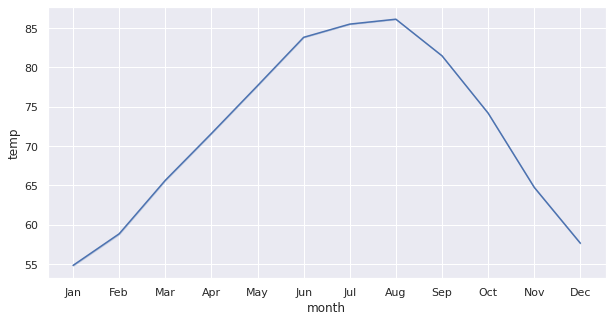

In [52]:
sns.lineplot(data=df, x="month", y="temp")

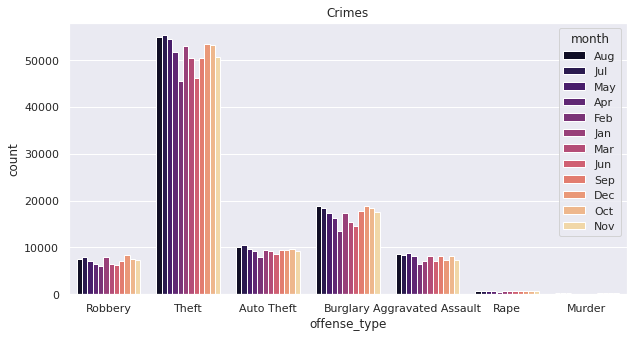

In [27]:
sns.countplot(x = 'offense_type', hue = 'month', data = df, palette = 'magma')
plt.title('Crimes')
plt.show()

In [59]:
df.loc[(df.offense_type == 'Rape') & (df.offense_type == 'Murder')]


,datetime,month,year,temp,offense_type


In [60]:
df.offense_type.value_counts()

Theft                 618702
Burglary              204088
Auto Theft            112165
Aggravated Assault     93853
Robbery                86377
Rape                    7769
Murder                  2147
Name: offense_type, dtype: int64

In [66]:
rm = df[df.offense_type.isin(['Rape','Murder'])]
rm.head()

,datetime,month,year,temp,offense_type
1115538,2009-01-01 08:00:00,Jan,2009,49,Rape
1103148,2009-01-01 09:00:00,Jan,2009,48,Rape
1103149,2009-01-01 09:00:00,Jan,2009,48,Rape
1112170,2009-01-01 12:00:00,Jan,2009,45,Rape
1123448,2009-01-01 14:00:00,Jan,2009,45,Rape


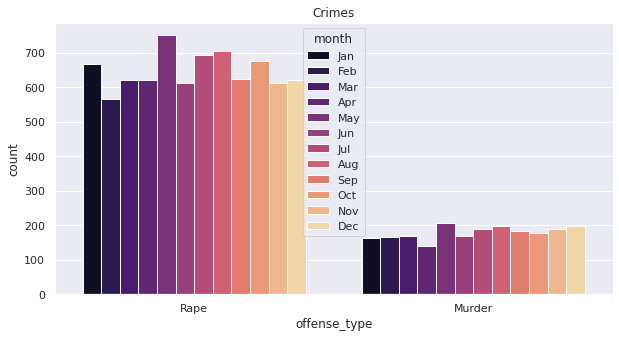

In [67]:
sns.countplot(x = 'offense_type', hue = 'month', data = rm, palette = 'magma')
plt.title('Crimes')
plt.show()

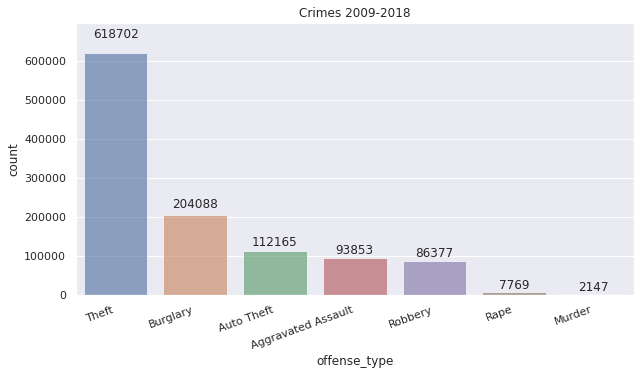

In [74]:
barplot(df,'offense_type',"Crimes 2009-2018",save=False)

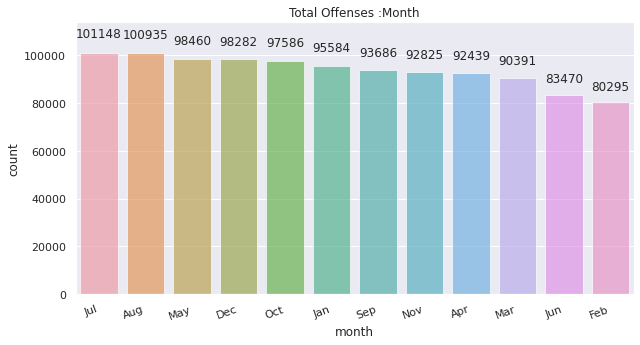

In [76]:
t='Total Offenses :Month'
xlab = ''
ylab = ''

barplot(df,'month',t,save=False)

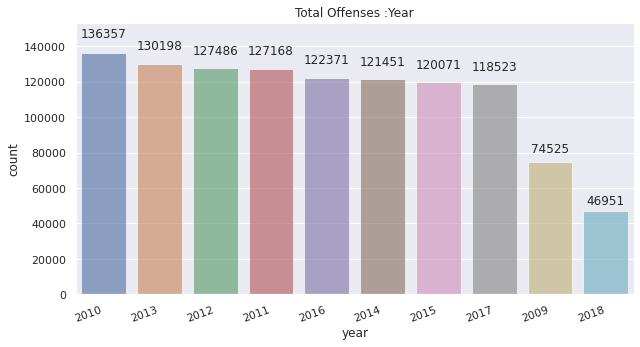

In [78]:
t='Total Offenses :Year'

barplot(df,'year',t,save=False)